In [1]:
import pandas as pd
import os
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt

# Load the font from a file
font_path = os.path.join(os.path.expanduser("~"), '.fonts/Palatino Linotype/palatinolinotype_roman.ttf') 
custom_font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path) 
print(custom_font.get_name())
plt.rcParams["font.family"] = "Palatino Linotype"

Palatino Linotype


In [2]:
STEERING_GOALS = ["reading_difficulty", "textual_diversity", "text_length", "formality"]

# Steerability metric calculation

In [ ]:
CUT_POINTS = np.array([-1., -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.])

def bin_delta(delta, cutpoints):
    return np.digitize(delta, cutpoints[1:-1], right=False)

def get_dynamic_cutpoints(start_vector, cut_points=CUT_POINTS):
    # (N, d, 1) * (1, 1, C) => (N, d, C)
    return np.clip(start_vector[..., None] + cut_points[None, None, :], 0, 1)

def scalar_rejection(a, b): # b onto a
    b_norm = np.sum(b * b, axis=1).values + 1e-8
    proj = (np.sum(a * b, axis=1) / b_norm).values.reshape(-1, 1) * b  # shape [n, d]
    rejection_vec = a - proj
    rejection = np.linalg.norm(rejection_vec, axis=1)
    return rejection

def scalar_projection(a, b):
    return np.sum(a * b, axis=1) / (np.linalg.norm(b, axis=1) + 1e-8)

def get_dist_to_goal(df, by_goal=False, steering_goals=STEERING_GOALS, cut_points=None):
    source = df[[f"source_{goal}" for goal in steering_goals]]
    output = df[[f"output_{goal}" for goal in steering_goals]]
    target = df[[f"target_{goal}" for goal in steering_goals]]
    target_corrected = target.where(pd.notnull(target), source.values)
    if cut_points is None:
        if by_goal:
            dists = pd.DataFrame(target_corrected.values - output.values, columns=steering_goals)
        else:
            dists = np.linalg.norm(output.values - target_corrected.values, axis=1)
    else:
        dynamic_cutpoints = get_dynamic_cutpoints(source.values)
        target_bins = np.sum(target_corrected.values[..., None] >= dynamic_cutpoints, axis=2) - 1
        obs_bins = np.sum(output.values[..., None] >= dynamic_cutpoints, axis=2) - 1
        if by_goal:
            dists = pd.DataFrame((obs_bins - target_bins) / (len(cut_points) - 1), columns=steering_goals)
        else:
            dists = np.linalg.norm((obs_bins - target_bins) / (len(cut_points) - 1), axis=1)
    return dists

def get_dist_from_source(df, by_goal=False, steering_goals=STEERING_GOALS, cut_points=None): # \hat{z} - z_0
    source = df[[f"source_{goal}" for goal in steering_goals]]
    output = df[[f"output_{goal}" for goal in steering_goals]]     
    if cut_points is None:      
        if by_goal:
            dists = pd.DataFrame(output.values - source.values, columns=steering_goals)
        else:
            dists = np.linalg.norm(output.values - source.values, axis=1)
    else:
        # number of bins actually moved
        assert len(cut_points) % 2 == 0 # if there is a "null" bin, bin # is odd, so cutpoint count is even
        bins_per_side = (len(cut_points) - 2) / 2
        dynamic_cutpoints = get_dynamic_cutpoints(source.values)
        output_bins = np.sum(output.values[..., None] >= dynamic_cutpoints, axis=2) - 1 - bins_per_side # in the 7-bin direct prompt, bin 3 is always the original source text
        if by_goal:
            dists = pd.DataFrame(output_bins / (len(cut_points) - 1), columns=steering_goals)
        else:
            dists = np.linalg.norm(output_bins / (len(cut_points) - 1), axis=1)
    return dists


def get_dist_requested(df, by_goal=False, steering_goals=STEERING_GOALS, cut_points=None): # z^* - z_0
    source = df[[f"source_{goal}" for goal in steering_goals]]
    target = df[[f"target_{goal}" for goal in steering_goals]]  
        
    target_corrected = target.where(pd.notnull(target), source.values)
    if cut_points is None:
        if by_goal:
            dists = pd.DataFrame(target_corrected.values - source.values, columns=steering_goals)
        else:
            dists = np.linalg.norm(source.values - target_corrected.values, axis=1)
    else:
        # number of bins of movement requested 
        assert len(cut_points) % 2 == 0
        bins_per_side = (len(cut_points) - 2) / 2
        delta = df[[f"delta_{goal}" for goal in steering_goals]]
        delta_corrected = delta.fillna(0.).values
        delta_bins = np.sum(delta_corrected[..., None] >= cut_points, axis=2) - 1 - bins_per_side
        if by_goal:
            dists = pd.DataFrame(delta_bins / (len(cut_points) - 1), columns=steering_goals)
        else:
            dists = np.linalg.norm(delta_bins / (len(cut_points) - 1), axis=1)
    return dists

def get_orthogonality(df, steering_goals=STEERING_GOALS, normalize=True, cut_points=None):
    dist_to_goal = get_dist_to_goal(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)
    dist_from_goal_actual = get_dist_from_source(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)
    dist_requested = get_dist_requested(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)

    dist_from_goal_norm = np.linalg.norm(dist_from_goal_actual, axis=1) 
    dist_requested_norm = np.linalg.norm(dist_requested, axis=1)

    denom = dist_from_goal_norm + 1e-4 * (dist_requested_norm + 1e-8)
    rej = scalar_rejection(dist_to_goal, dist_requested)
    if normalize:
        ortho = np.clip(rej / denom, 0, 1) 
    else:
        ortho = rej
    return ortho




def get_miscalibration(df, steering_goals=STEERING_GOALS, normalize=True, cut_points=None):
    dist_to_goal = get_dist_to_goal(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)
    dist_from_goal_ideal = get_dist_requested(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)
    denom = np.linalg.norm(dist_from_goal_ideal, axis=1) + 1e-8
    abs_proj_dist = np.abs(scalar_projection(dist_to_goal, dist_from_goal_ideal))
    if normalize:
        miscal = abs_proj_dist / denom
    else:
        miscal = abs_proj_dist 
    return miscal

# Plotting helpers

In [7]:
def preview_samples(df, n=10, topk=None, ranking_function=get_dist_to_goal, steering_goals=STEERING_GOALS):
    def wrap_and_truncate(text):
        if not isinstance(text, str):
            return text
        wrapped = '\n'.join([text[i:i+100] for i in range(0, len(text), 100)])
        return wrapped[:5000] + ('...' if len(text) > 5000 else '')

    with pd.option_context('display.max_colwidth', None):  # Allow full colwidth before manual wrapping
        subset = df.filter(regex="^(text$|instruction$|llm_response|source_(?!text_is_a)|output_(?!raw))", axis=1)
        if topk is None:
            sample = subset.sample(n=n, random_state=42)
            for col in ['text', 'instruction', 'llm_response']:
                if col in sample.columns:
                    sample[col] = sample[col].apply(wrap_and_truncate)
        else:
            print(f"`topk` is not None ({topk}) -- ignoring n.")
            indices = np.argsort(ranking_function(df, steering_goals=steering_goals))
            if topk > 0:
                sample = subset.iloc[indices[:topk]] # best
            else: # negative 
                sample = subset.iloc[indices[topk:]] # worst
        display(sample) 

def fix_violin(violin, color):
    for pc in violin['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
        pc.set_zorder(2)

    violin['cbars'].set_color(color) 
    violin['cbars'].set_zorder(1)

    violin['cmedians'].set_color('black')
    violin['cmedians'].set_linewidth(1.)
    violin['cmedians'].set_zorder(2)

    violin['cmins'].set_color('black')  # Minimum horizontal line
    violin['cmins'].set_linewidth(1.)
    violin['cmaxes'].set_color('black')  # Maximum horizontal line
    violin['cmaxes'].set_linewidth(1.)
    violin['cmins'].set_zorder(1)
    violin['cmaxes'].set_zorder(1)

def get_outlier_mask(series):
    lo, hi = np.percentile(series, [2.5, 97.5])
    outlier_mask = (series > hi) | (series < lo)
    return outlier_mask

def create_violin_subplot(data, position, color, ax, text_height, scatter_sz=25, text_offset=0.2, fontsize=8):

    def fmt_val(val):
        return f"{val:.3f}".lstrip("0")

    outlier_mask = get_outlier_mask(data)
    truncated_data = data[~outlier_mask]
    violin = ax.violinplot(
        truncated_data,
        positions=[position], 
        widths=0.6,
        bw_method=0.15,
        showmedians=True,
    )
    ax.scatter([position] * outlier_mask.sum(), data[outlier_mask], alpha=0.2,
                color=color, marker=".", s=scatter_sz, linewidths=0.5, edgecolor="gray")
    fix_violin(violin, color)
    mean_val = np.median(data)
    #std_val = np.std(data)
    iqr_val = np.percentile(data, 75) - np.percentile(data, 25)
    ax.text(
        position, text_height, #np.quantile(data, 0.999) * 1.0, 
        f"{fmt_val(mean_val)}\n({fmt_val(iqr_val)})",
        ha="center", va="bottom", fontsize=fontsize, fontweight="bold"
    )

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(*rgb)

def interpolate_colors(start_hex, end_hex, n):
    start_rgb = hex_to_rgb(start_hex)
    end_rgb = hex_to_rgb(end_hex)
    
    interpolated = []
    for i in range(n):
        ratio = i / (n - 1) if n > 1 else 0
        rgb = tuple(
            int(start_rgb[j] + (end_rgb[j] - start_rgb[j]) * ratio)
            for j in range(3)
        )
        interpolated.append(rgb_to_hex(rgb))
    
    return interpolated

def get_grounded_subset(df, flip=False):
    mask = (df["rationale_approved"] & (df["answer"] == "Yes")) | (~df["rationale_approved"] & (df["answer"] == "No"))
    print(f"{mask.sum()}/{len(df)} rewrites passed groudnedness check | {(df['answer'] == 'No').sum()} flagged | {(~df['rationale_approved']).sum()} overruled")
    if flip:
        mask = ~mask
    return df.loc[mask]

def compute_bar_positions(total_bars, group_sizes, spacing=0.3):
    positions = []

    # Handle integer: divide evenly
    if isinstance(group_sizes, int):
        per_group = total_bars // group_sizes
        group_sizes_list = [per_group] * group_sizes
        remainder = total_bars % group_sizes
        for i in range(remainder):
            group_sizes_list[i] += 1
    else:
        group_sizes_list = group_sizes

    current_base = 0
    for size in group_sizes_list:
        positions.extend([current_base + i for i in range(size)])
        current_base += size + spacing

    return positions


def plot_steerability_metrics(results, colors, names,
                        legend_y, group_sizes=1, control=None,
                          legend_title="Model", save=None,
                          steering_goals=STEERING_GOALS,
                          exclude_degenerate=True, wide=True,
                          steer_height=0.7, miscal_height=2., ortho_height=1.2, 
                          figsize=(8, 2), suptitle=None,
                          suptitle_y=0.9, normalize=True,
                          cut_points=None, ncols=None):
    handles = []
    positions = compute_bar_positions(len(results), group_sizes)

    if wide:
        fig, axs = plt.subplots(1, 3, figsize=figsize)
    else:
        fig, axs = plt.subplots(3, 1, figsize=figsize)

    sup = None
    if suptitle is not None:
        sup = fig.suptitle(suptitle, y=suptitle_y)

    axs[0].set_ylabel(r"$\vert\vert \mathbf{\hat{z}} - \mathbf{z}^* \vert\vert_2$")
    axs[1].set_ylabel(r"Miscalibration")
    axs[2].set_ylabel(r"Orthogonality")

    axs[0].set_xlabel("")
    axs[1].set_xlabel("")
    axs[2].set_xlabel("")

    if control is not None:
        control_dist = get_dist_to_goal(control, steering_goals=steering_goals, cut_points=cut_points)
        control_miscal = get_miscalibration(control, steering_goals=steering_goals, normalize=normalize, cut_points=cut_points)
        control_ortho = get_orthogonality(control, steering_goals=steering_goals, normalize=normalize, cut_points=cut_points)

    for i, (df, color) in enumerate(zip(results, colors)):
        if exclude_degenerate:
            df = get_grounded_subset(df)
        dist = get_dist_to_goal(df, steering_goals=steering_goals, cut_points=cut_points)
        if control is not None:
            dist = dist - control_dist
            print("% improved, steerability:", (dist < 0).mean())
        create_violin_subplot(dist, positions[i], color, axs[0], steer_height)

        miscal = get_miscalibration(df, steering_goals=steering_goals, normalize=normalize, cut_points=cut_points)
        if control is not None:
            miscal = miscal - control_miscal
            print("% improved, miscal:", (miscal < 0).mean())
        create_violin_subplot(miscal, positions[i], color, axs[1], miscal_height)

        ortho = get_orthogonality(df, steering_goals=steering_goals, normalize=normalize, cut_points=cut_points)
        if control is not None:
            ortho = ortho - control_ortho
            print("% improved, ortho:", (ortho < 0).mean())

        create_violin_subplot(ortho, positions[i], color, axs[2], ortho_height)

        # for legend
        patch = mpatches.Patch(color=color)
        handles.append(patch)

    for ax in axs:
        ax.tick_params(axis="x", length=0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlim((min(positions) - 1, max(positions) + 1))
        ax.set_xticklabels([])


    if control is not None:
        axs[0].set_ylim((-0.7, 0.5))
        axs[1].set_ylim((-2, 3.))
        axs[2].set_ylim((-1, 1.02))
        axs[0].hlines([-1.0, -0.5, 0, 0.5, 1.0, 1.5], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[1].hlines([-2., 0., 2., 4.], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[2].hlines([-1., -0.5, 0, 0.5, 1], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
    else:
        axs[0].set_ylim((-0.05, 1.5))
        axs[1].set_ylim((-0.05, 3.))
        axs[2].set_ylim((-0.05, 1.02))
        axs[0].hlines([0, 0.4, 0.8, 1.2], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[1].hlines([0, 1, 2, 3], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[2].hlines([0, 0.25, 0.5, 0.75, 1], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)

    #fig.suptitle(suptitle)
    lgd = fig.legend(
        handles,
        names, # + ["Perfect steerability"],
        ncols=min(len(results) + 1, 7 if wide else 4) if ncols is None else ncols,
        loc="lower center",
        bbox_to_anchor=(0.5, legend_y),
        title=legend_title,
    )
    fig.tight_layout()
    if save is not None:
        fig.savefig(f"figures/{save}.pdf", bbox_inches="tight", bbox_extra_artists=(lgd, sup))
    fig.show()
    return dist, miscal, ortho



2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
['reading_difficulty', 'textual_diversity', 'text_length', 'formality'] True [-1.  -0.5 -0.2 -0.1  0.1  0.2  0.5  1. ]
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled
['reading_difficulty', 'textual_diversity', 'text_length', 'formality'] True [-1.  -0.5 -0.2 -0.1  0.1  0.2  0.5  1. ]
2048/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
['reading_difficulty', 'textual_diversity', 'text_length', 'formality'] True [-1.  -0.5 -0.2 -0.1  0.1  0.2  0.5  1. ]
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
['reading_difficulty', 'textual_diversity', 'text_length', 'formality'] True [-1.  -0.5 -0.2 -0.1  0.1  0.2  0.5  1. ]
2047/2048 rewrites passed groudnedness check | 6 flagged | 5 overruled
['reading_difficulty', 'textual_diversity', 'text_length', 'formality'] True [-1.  -0.5 -0.2 -0.1  0.1  0.2  0.5  1. ]
2047/2048 rewrites passed groudnedness check | 5 f

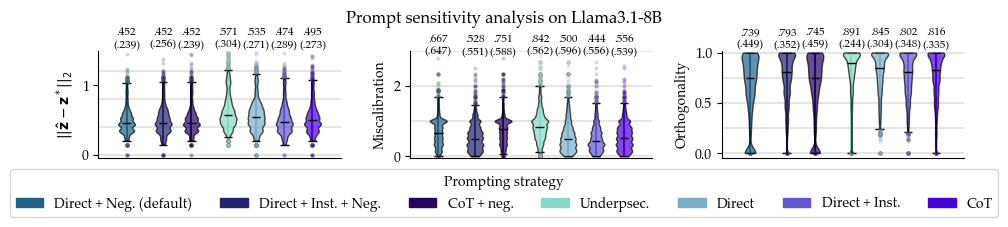

In [68]:
llama_results = [
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_neg_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_neg_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_underspec_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_judged.csv", index_col=0),

    #pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_one_to_ten_judged.csv", index_col=0),
    #pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_one_to_ten_neg_judged.csv", index_col=0),


    #pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_inst_only_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_judged.csv", index_col=0),

]




llama3_1_colors = interpolate_colors("#86d9c6", "#4900db",  6)
llama3_1_neg_colors = interpolate_colors("#226287", "#240463", 4)
final_colors = [
    llama3_1_neg_colors[0],
    llama3_1_neg_colors[2],
    llama3_1_neg_colors[3],
    llama3_1_colors[0],
    llama3_1_colors[1], 
    #llama3_1_colors[2], llama3_1_neg_colors[1],
    llama3_1_colors[3], 
    #llama3_1_colors[4],
    llama3_1_colors[5], 
]

llama3_1_names = ["Direct + Neg. (default)", "Direct + Inst. + Neg.", "CoT + neg.", "Underpsec.", "Direct", 
                  #"1-10 scale", "1-10 scale + Neg.",
                  "Direct + Inst.", "CoT"]

_ = plot_steerability_metrics(
    llama_results,
    final_colors,
    llama3_1_names,
    -0.22,
    group_sizes=[1, 2, 4],
    suptitle="Prompt sensitivity analysis on Llama3.1-8B",
    suptitle_y=0.85,
    figsize=(9.5, 2.),
    legend_title="Prompting strategy",
    save="llama3.1_prompts_v3_disc",
    steer_height=1.5, miscal_height=2.8, ortho_height=1.02,
    cut_points=CUT_POINTS
)

In [10]:
get_orthogonality(llama_results[0], cut_points=CUT_POINTS)

array([1.        , 1.        , 1.        , ..., 0.92203962, 0.54140353,
       0.71366079])

,reading_difficulty,textual_diversity,text_length,formality
0,0.285714,0.428571,0.000000,0.142857
1,0.285714,0.142857,0.000000,-0.285714
2,-0.285714,0.142857,0.000000,0.428571
3,0.285714,0.428571,0.000000,-0.285714
4,0.000000,0.285714,0.142857,-0.142857
...,...,...,...,...
2043,-0.285714,-0.285714,0.285714,0.142857
2044,0.142857,0.428571,0.000000,-0.285714
2045,0.428571,0.142857,-0.285714,-0.142857
2046,0.142857,-0.285714,0.000000,0.000000


In [65]:
from steerability.steerability_metrics import (
    get_orthogonality as py_ortho,
    get_dist_from_source as py_dist_from_source,
    get_dist_requested as py_dist_requested,
    get_dist_to_goal as py_dist_to_goal,
    scalar_rejection as py_rejection,
)

dist_to_goal = get_dist_to_goal(llama_results[0], by_goal=True, steering_goals=STEERING_GOALS, cut_points=CUT_POINTS)
dist_from_goal_actual = get_dist_from_source(llama_results[0], by_goal=True, steering_goals=STEERING_GOALS, cut_points=CUT_POINTS)
dist_requested = get_dist_requested(llama_results[0], by_goal=True, steering_goals=STEERING_GOALS, cut_points=CUT_POINTS)

dist_from_goal_norm = np.linalg.norm(dist_from_goal_actual, axis=1) 
dist_requested_norm = np.linalg.norm(dist_requested, axis=1)

denom = dist_from_goal_norm + 1e-4 * (dist_requested_norm + 1e-8)
rej = scalar_rejection(dist_to_goal, dist_requested)
ortho = np.clip(rej / denom, 0, 1) 

fn_dist_to_goal = py_dist_to_goal(llama_results[0], by_goal=True)
fn_dist_from_goal_actual = py_dist_from_source(llama_results[0], by_goal=True)
fn_dist_requested = py_dist_requested(llama_results[0], by_goal=True)

fn_dist_from_goal_norm = np.linalg.norm(fn_dist_from_goal_actual, axis=1) 
fn_dist_requested_norm = np.linalg.norm(fn_dist_requested, axis=1)

fn_denom = fn_dist_from_goal_norm + 1e-4 * (fn_dist_requested_norm + 1e-8)
fn_rej = py_rejection(fn_dist_to_goal, fn_dist_requested)
fn_ortho = np.clip(fn_rej / fn_denom, 0, 1) 

print(fn_ortho)
print(py_ortho(llama_results[0]))
print(get_orthogonality(llama_results[0], normalize=True, cut_points=CUT_POINTS))

np.allclose(
    py_ortho(llama_results[0]),
    get_orthogonality(llama_results[0], normalize=True, steering_goals=STEERING_GOALS, cut_points=CUT_POINTS),
)

[3.49999981e-04 8.16213836e-01 9.81720767e-01 ... 9.15135710e-01
 5.38379125e-01 7.01075907e-01]
[3.49999981e-04 8.16213836e-01 9.81720767e-01 ... 9.15135710e-01
 5.38379125e-01 7.01075907e-01]
['reading_difficulty', 'textual_diversity', 'text_length', 'formality'] True [-1.  -0.5 -0.2 -0.1  0.1  0.2  0.5  1. ]
[1.         1.         1.         ... 0.92203962 0.54140353 0.71366079]
['reading_difficulty', 'textual_diversity', 'text_length', 'formality'] True [-1.  -0.5 -0.2 -0.1  0.1  0.2  0.5  1. ]


False

In [66]:
CUT_POINTS.dtype

dtype('float64')

In [ ]:
dist_to_goal = get_dist_to_goal(df, by_goal=True, steering_goals=STEERING_GOALS, cut_points=CUT_POINTS)
dist_from_goal_actual = get_dist_from_source(df, by_goal=True, steering_goals=STEERING_GOALS, cut_points=CUT_POINTS)
dist_requested = get_dist_requested(df, by_goal=True, steering_goals=STEERING_GOALS, cut_points=CUT_POINTS)

dist_from_goal_norm = np.linalg.norm(dist_from_goal_actual, axis=1) 
dist_requested_norm = np.linalg.norm(dist_requested, axis=1)

denom = dist_from_goal_norm + 1e-4 * (dist_requested_norm + 1e-8)
rej = scalar_rejection(dist_to_goal, dist_requested)
ortho = np.clip(rej / denom, 0, 1) 


In [ ]:
llama_results = [
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_underspec_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),


    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_neg_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_inst_only_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_neg_judged.csv", index_col=0),
]




llama3_1_colors = interpolate_colors("#86d9c6", "#4900db",  5)
llama3_1_neg_colors = interpolate_colors("#226287", "#240463", 3)
final_colors = [
    llama3_1_colors[0],
    llama3_1_colors[1], llama3_1_neg_colors[0],
    #llama3_1_colors[2], llama3_1_neg_colors[1],
    llama3_1_colors[2], llama3_1_neg_colors[1],
    llama3_1_colors[3],
    llama3_1_colors[4], llama3_1_neg_colors[2]
]

llama3_1_names = ["Underspec.", "Direct", "Direct + Neg.",
                 # "1-10 scale", "1-10 scale + Neg.",
                  "CoT", "CoT + neg.", "Inst.",  "Direct + Inst.", "Direct + Inst. + Neg."]



2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 5 overruled
2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
2044/2048 rewrites passed groudnedness check | 5 flagged | 1 overruled
2047/2048 rewrites passed groudnedness check | 5 flagged | 4 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled


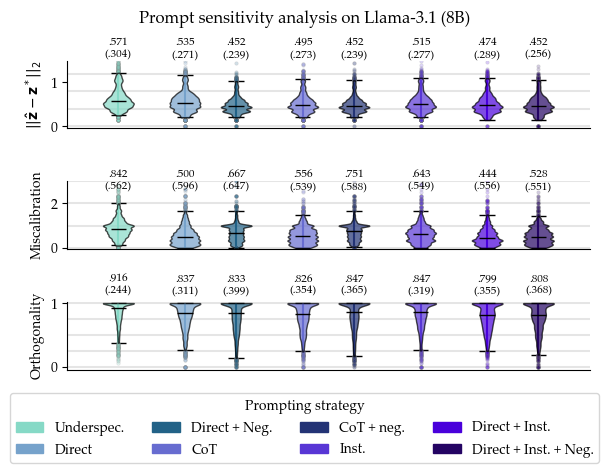

In [ ]:
_ = plot_steerability_metrics(
    llama_results,
    final_colors,
    llama3_1_names,
    -0.2,
    group_sizes=[1, 2, 2, 1, 2],
    suptitle="Prompt sensitivity analysis on Llama-3.1 (8B)",
    suptitle_y=0.95,
    figsize=(6, 4.),
    wide=False,
    legend_title="Prompting strategy",
    save="llama3.1_prompts_all",
    steer_height=1.5, miscal_height=2.5, ortho_height=1.1,
    cut_points=CUT_POINTS,
)

In [ ]:
def extract_oracle_best(df, mode="best", steering_goals=STEERING_GOALS):
    target_goals = [f"target_{goal}" for goal in steering_goals]
    if mode == "best":
        best_completions = df.groupby(["text"] + target_goals) \
            .apply(lambda group: group.iloc[get_dist_to_goal(group, steering_goals=steering_goals).argmin()]) \
            .reset_index(drop=True)
    elif mode == "worst":
        best_completions = df.groupby(["text"] + target_goals) \
            .apply(lambda group: group.iloc[get_dist_to_goal(group, steering_goals=steering_goals).argmax()]) \
            .reset_index(drop=True)
    elif mode == "median":
        def argmedian(group):
            target_dist = get_dist_to_goal(group, steering_goals=steering_goals)
            med = target_dist.median()
            med_dist = np.abs(target_dist - med)
            return med_dist.argmin()
        
        best_completions = df.groupby(["text"] + target_goals) \
            .apply(lambda group: argmedian(group)) \
            .reset_index(drop=True)
    else:
        raise ValueError()
    return best_completions

def post_process_oracle(df, steering_goals=STEERING_GOALS):
    source = df[[f"source_{goal}" for goal in steering_goals]]
    target = df[[f"target_{goal}" for goal in steering_goals]] 
    delta = df[[f"delta_{goal}" for goal in steering_goals]]  
 
    df.loc[:, [f"target_{goal}" for goal in steering_goals]] = np.where(target == -1., source.values, target)
    df.loc[:, [f"delta_{goal}" for goal in steering_goals]] = np.where(delta == -1., 0., delta)
    return df


2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 1 flagged | 1 overruled
2047/2048 rewrites passed groudnedness check | 9 flagged | 8 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled
2046/2048 rewrites passed groudnedness check | 3 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 1 flagged | 1 overruled


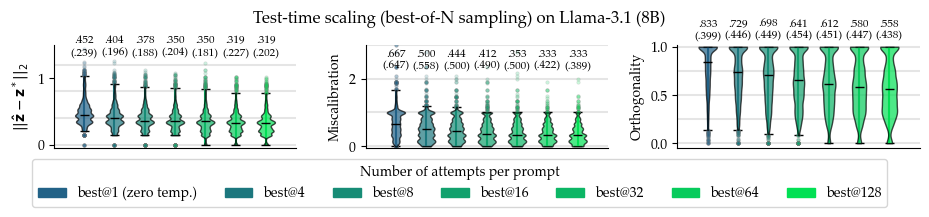

In [ ]:

llama_oracle = [
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b4_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b8_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b16_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b32_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b64_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b128_judged.csv", index_col=0)),

]

llama3_1_colors = interpolate_colors("#226287", "#02e054", len(llama_oracle))
llama3_1_names = ["best@1 (zero temp.)", 
                  "best@4",
                  "best@8", "best@16", "best@32", "best@64", "best@128"]

_ = plot_steerability_metrics(
    llama_oracle,
    llama3_1_colors,
    llama3_1_names,
    -0.22,
    group_sizes=1,
    suptitle="Test-time scaling (best-of-N sampling) on Llama-3.1 (8B)",
    suptitle_y=0.8,
    legend_title="Number of attempts per prompt",
    save="llama3.1_oracle_disc",
    figsize=(9.5, 2),
    cut_points=CUT_POINTS,
    steer_height=1.3,
    miscal_height=2.2,
    ortho_height=1.05,
)


2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 7 overruled
2047/2048 rewrites passed groudnedness check | 19 flagged | 18 overruled


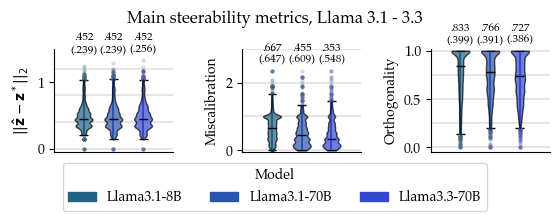

In [ ]:
models = [
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_70b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.3_70b_judged.csv", index_col=0),
]


model_colors = interpolate_colors("#226287", "#3448cf", 3) 
model_names = ["Llama3.1-8B", "Llama3.1-70B",
               "Llama3.3-70B"]


_ = plot_steerability_metrics(
    models,
    model_colors,
    model_names,
    -0.22,
    group_sizes=[3], 
    suptitle="Main steerability metrics, Llama 3.1 - 3.3",
    suptitle_y=0.82,
    legend_title="Model",
    figsize=(5.8, 2),
    save="steerability_llama_only",
    cut_points=CUT_POINTS,
     steer_height=1.4,
    miscal_height=2.5,
    ortho_height=1.05,
)


In [6]:
every_model = [
    pd.read_csv("./judge_results/grounding/v2.1_llama3_8b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3_70b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_70b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.3_70b_judged.csv", index_col=0),

    pd.read_csv("./judge_results/grounding/v2.1_gpt35_turbo_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4_turbo_2024_04_09_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4o_2024_08_06_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4.1_2025_04_14_judged.csv", index_col=0),

    pd.read_csv("./judge_results/grounding/v2.1_o1_mini_2024_09_12_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_o3_mini_2025_01_31_judged.csv", index_col=0),

    pd.read_csv("./judge_results/grounding/v2.1_deepseek_8b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_deepseek_70b_judged.csv", index_col=0),

    pd.read_csv("./judge_results/grounding/qwen_4b_zerobrain_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/qwen_32b_zerobrain_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/qwen_moe_zerobrain_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/qwen_4b_bigbrain_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/qwen_32b_bigbrain_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/qwen_moe_bigbrain_judged.csv", index_col=0),

]


model_colors = interpolate_colors("#68adbd", "#3448cf", 5) + interpolate_colors("#6e563b", "#dbc72e", 4) + interpolate_colors("#8c5303", "#c76c38", 2) \
    + interpolate_colors("#ba3c23", "#f02252", 2) + interpolate_colors("#d3c9d6", "#554f57", 6)
model_names = ["Llama3-8B", "Llama3-70B",
    "Llama3.1-8B", "Llama3.1-70B",
               "Llama3.3-70B",
               "GPT-3.5 turbo",
               "GPT-4 turbo",
               "GPT-4o", "GPT-4.1", 
               "o1-mini", "o3-mini",
               "Deepseek-8B", "Deepseek-70B",
               "Qwen3-4B", "Qwen3-32B", "Qwen3-30B-A3B",
            "Qwen3-4B-Thinking", "Qwen3-32B-Thinking", "Qwen3-30B-A3B-Thinking",]




2048/2048 rewrites passed groudnedness check | 8 flagged | 8 overruled
2048/2048 rewrites passed groudnedness check | 8 flagged | 8 overruled
2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 7 overruled
2047/2048 rewrites passed groudnedness check | 19 flagged | 18 overruled
2045/2048 rewrites passed groudnedness check | 41 flagged | 40 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2026/2048 rewrites passed groudnedness check | 23 flagged | 1 overruled
2024/2048 rewrites passed groudnedness check | 23 flagged | 4 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 5 overruled
2046/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled
2046/2048 rewrites passed groudnedness check | 5 flagged | 3 overruled


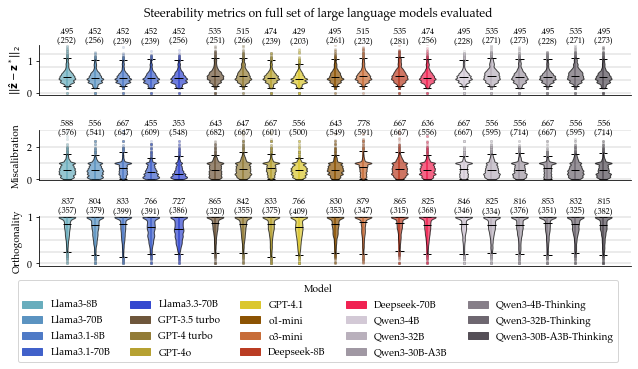

In [7]:
_ = plot_steerability_metrics(
    every_model,
    model_colors,
    model_names,
    -0.3,
    group_sizes=[5, 4, 2, 2, 6],
    suptitle="Steerability metrics on full set of large language models evaluated",
    suptitle_y=0.95,
    legend_title="Model",
    figsize=(9., 4),
    wide=False,
    save="steerability_every_model",
    cut_points=CUT_POINTS,
    steer_height=1.5, miscal_height=2.6, ortho_height=1.05,
    ncols=5,
)

## Trained models

In [17]:
def decompose_entangled(*dfs, goal1="formality", goal2="reading_difficulty"):
    results = []
    for df in dfs:
        results.append([
            df.loc[df[f"delta_{goal1}"] * df[f"delta_{goal2}"] > 0], df.loc[df[f"delta_{goal1}"] * df[f"delta_{goal2}"] < 0], 
        ])
    return list(chain.from_iterable(zip(*results)))

def brighten(hex_color, amount=0.5):
    hex_color = hex_color.lstrip("#")
    r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
    r = int(r + (255 - r) * amount)
    g = int(g + (255 - g) * amount)
    b = int(b + (255 - b) * amount)
    return f"#{r:02x}{g:02x}{b:02x}"

627/627 rewrites passed groudnedness check | 0 flagged | 0 overruled
626/627 rewrites passed groudnedness check | 0 flagged | 1 overruled
627/627 rewrites passed groudnedness check | 0 flagged | 0 overruled
397/397 rewrites passed groudnedness check | 0 flagged | 0 overruled
397/397 rewrites passed groudnedness check | 0 flagged | 0 overruled
397/397 rewrites passed groudnedness check | 0 flagged | 0 overruled


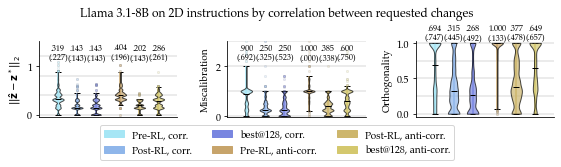

In [ ]:
from itertools import chain

results_2d = [
    pd.read_csv("./judge_results/grounding/stage_0_2d_judged.csv"),
    pd.read_csv("./judge_results/grounding/vanilla_rl_2d_judged.csv"),
    post_process_oracle(pd.read_csv("./judge_results/grounding/meta_test_b128_2d_judged.csv"), steering_goals=["reading_difficulty", "formality"]),
]




inst_by_corr = decompose_entangled(*results_2d)

names = [
    "Pre-RL, corr.", "Post-RL, corr.", "best@128, corr.",
    "Pre-RL, anti-corr.", "Post-RL, anti-corr.", "best@128, anti-corr."
    ]

vanilla_colors = interpolate_colors("#68adbd", "#3448cf", 2)
corr_colors = interpolate_colors("#a6e6f5", "#7986e0", 3)
anticorr_colors = interpolate_colors("#c7a46b", "#d4c86e", 3)


_ = plot_steerability_metrics(
    inst_by_corr,
    corr_colors + anticorr_colors,
    names,
    -0.22,
    group_sizes=[3, 3],
    suptitle="Llama 3.1-8B on 2D instructions by correlation between requested changes",
    suptitle_y=0.88,
    legend_title="",
    figsize=(8., 2.),
    save="steer_tuning_entangling",
    steering_goals=["reading_difficulty", "formality"],
    normalize=True,
    ncols=3,
    cut_points=CUT_POINTS,
    steer_height=1.1, miscal_height=2.2, ortho_height=1.02,
)


In [ ]:
names = [
    "Llama3.3-70B, corr.", "GPT-4.1, corr.", "Deepseek-70B, corr.", "Qwen3-32B (thinking), corr."
    "Llama3.3-70B, anti-corr.", "GPT-4.1, anti-corr.", "Deepseek-70B, anti-corr.", "Qwen3-32B (thinking), anti-corr.",
]
inst_by_corr = decompose_entangled(every_model[4], every_model[8], every_model[12], every_model[-2])


llama_colors = interpolate_colors("#226287", "#3448cf", 3) 
gpt_colors = interpolate_colors("#6e563b", "#dbc72e", 4)[1:]
deepseek_colors = interpolate_colors("#ba3c23", "#f02252", 2)
qwen_colors =  interpolate_colors("#d3c9d6", "#554f57", 6)

corr_colors = [llama_colors[-1], gpt_colors[-1], deepseek_colors[-1], qwen_colors[-2]]
anticorr_colors = [brighten(c) for c in corr_colors]
all_colors = corr_colors + anticorr_colors


indices = [0, 4, 1, 5, 2, 6, 3, 7]
redone_inst = [inst_by_corr[i] for i in indices] # edit this to plot more model
redone_colors = [all_colors[i] for i in indices]
names = [names[i] for i in indices]

_ = plot_steerability_metrics(
    redone_inst,
    redone_colors,
    names,
    -0.12,
    group_sizes=[2, 2, 2, 2], #, 2, 2],
    suptitle="Instructions requesting correlated/anti-correlated changes\nin reading difficulty & formality", # between requested changes",
    suptitle_y=0.81,
    legend_title="",
    figsize=(9., 2.1),
    save="llama_entangled",
    normalize=True,
    cut_points=CUT_POINTS,
    ncols=4,
    steer_height=1.3, miscal_height=2.2, ortho_height=1.05,
)


NameError: name 'every_model' is not defined

2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2047/2048 rewrites passed groudnedness check | 3 flagged | 2 overruled


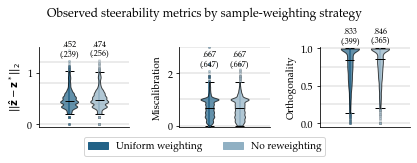

In [22]:
results_weighted = [
        pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv"),
        pd.read_csv("./judge_results/grounding/steerbench_unweighted_judged.csv"),

]

_ = plot_steerability_metrics(
    results_weighted,
    ["#226287", brighten("#226287")],
    ["Uniform weighting", "No reweighting"],
    -0.12,
    group_sizes=[2], #, 2, 2],
    suptitle="Observed steerability metrics by sample-weighting strategy", # between requested changes",
    suptitle_y=0.9,
    legend_title="",
    figsize=(6., 2.1),
    save="llama_uw_w",
    normalize=True,
    cut_points=CUT_POINTS,
    ncols=2,
    steer_height=1.3, miscal_height=2.2, ortho_height=1.05,
)

## Simple metric printouts

In [ ]:
# Table 2 metrics
def print_main_metrics(df, steering_goals=["reading_difficulty", "formality"], control=None):
    steering_err = get_dist_to_goal(df, steering_goals=steering_goals, cut_points=CUT_POINTS)
    miscal = get_miscalibration(df, steering_goals=steering_goals, cut_points=CUT_POINTS)
    ortho = get_orthogonality(df, steering_goals=steering_goals, cut_points=CUT_POINTS)

    if control is not None:
        control_steering_err = get_dist_to_goal(control, steering_goals=steering_goals, cut_points=CUT_POINTS)
        control_miscal = get_miscalibration(control, steering_goals=steering_goals, cut_points=CUT_POINTS)
        control_ortho = get_orthogonality(control, steering_goals=steering_goals, cut_points=CUT_POINTS)
        steering_err = steering_err - control_steering_err
        miscal = miscal - control_miscal
        ortho = ortho - control_ortho
        print(f"Improvement in steering err.: {np.median(steering_err):.3f}±{np.percentile(steering_err, 75) - np.percentile(steering_err, 25):.3f}")
        print(f"Improvement in miscalibration: {np.median(miscal):.3f}±{np.percentile(miscal, 75) - np.percentile(miscal, 25):.3f}")
        print(f"Improvement in orthogonality: {np.median(ortho):.3f}±{np.percentile(ortho, 75) - np.percentile(ortho, 25):.3f}")
    else:
        print(f"Steering err.: {np.median(steering_err):.3f}±{np.percentile(steering_err, 75) - np.percentile(steering_err, 25):.3f}")
        print(f"Miscalibration: {np.median(miscal):.3f}±{np.percentile(miscal, 75) - np.percentile(miscal, 25):.3f}")
        print(f"Orthogonality: {np.median(ortho):.3f}±{np.percentile(ortho, 75) - np.percentile(ortho, 25):.3f}")


control_df = pd.read_csv("./judge_results/grounding/tuning_stage_0_judged.csv")
print_main_metrics(pd.read_csv("./judge_results/grounding/ortho_only_judged.csv"), control=control_df)

Improvement in steering err.: 0.000±0.143
Improvement in miscalibration: 0.000±0.667
Improvement in orthogonality: -0.000±0.002


In [ ]:
print_main_metrics(pd.read_csv("./judge_results/grounding/vanilla_rl_judged.csv"), control=control_df)

Improvement in steering err.: -0.143±0.286
Improvement in miscalibration: -1.000±1.000
Improvement in orthogonality: -0.000±0.002


In [ ]:
print_main_metrics(pd.read_csv("./judge_results/grounding/tuning_stage_0_judged.csv"), control=control_df)

Improvement in steering err.: 0.143±0.286
Improvement in miscalibration: 1.000±1.000
Improvement in orthogonality: 0.000±0.002


In [ ]:
print_main_metrics(post_process_oracle(pd.read_csv("./judge_results/grounding/meta_test_b128_judged.csv"), steering_goals=["reading_difficulty", "formality"]), control=control_df)

Improvement in steering err.: -0.085±0.143
Improvement in miscalibration: -0.000±0.667
Improvement in orthogonality: -0.000±0.004


## BLEU analysis

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

import numpy as np

smoothing = SmoothingFunction()

bleu_results = {}
raw_results = {}
for name, df in zip(names, staged):
    ref_list = [[word_tokenize(r)] for r in df["text"]]  # list of reference lists
    cand_list = [word_tokenize(c) for c in df["llm_response"]]
    bleu_scores = pd.Series([sentence_bleu(ref, cand, smoothing_function=smoothing.method1) for ref, cand in zip(ref_list, cand_list)])
    bleu_results[name] = {
        "all": bleu_scores.mean(),
    }
    raw_results[name] = bleu_scores
    for dataset in df["source"].unique():
        bleu_results[name][dataset] = bleu_scores.loc[df["source"] == dataset].mean()



Pre-RL
Pre-RL, best@128
Post-RL


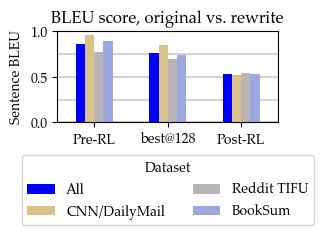

In [ ]:

df = pd.DataFrame(bleu_results).rename(lambda x: x.split(": ")[-1])
df = df.sort_index()
df.index = ["All", "CNN/DailyMail", "Reddit TIFU", "BookSum"]
df = df.rename({"Pre-RL, best@128": "best@128"}, axis=1)

# Plot
ax = df.T.plot(kind='bar', figsize=(3.2, 2.8), color=["blue"] + interpolate_colors("#d9c18b", "#9ea8de", 3))
ax.set_title("BLEU score, original vs. rewrite")

ax.hlines([0.0, 0.25, 0.5, 0.75], xmin=-0.5, xmax=len(df.columns), color="lightgray", zorder=-999)

ax.set_ylabel("Sentence BLEU")
plt.legend(title="Dataset", ncols=2, loc="upper center", bbox_to_anchor=(0.5, -0.28))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("./figures/sentence_bleu_post_rl.pdf")
plt.show()


In [ ]:
df # look at BLEU values

,Pre-RL,best@128,Post-RL
All,0.863649,0.760575,0.529285
CNN/DailyMail,0.957611,0.851698,0.521380
Reddit TIFU,0.772768,0.689209,0.536787
BookSum,0.892298,0.739728,0.527293


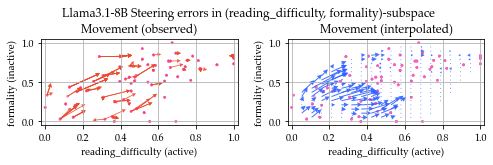

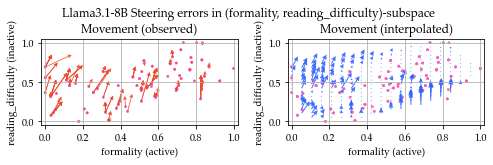

In [ ]:
get_pairwise_flows(staged[0], "Llama3.1-8B", exp_name="llama_pre_rl", steering_goals=["reading_difficulty", "formality"])

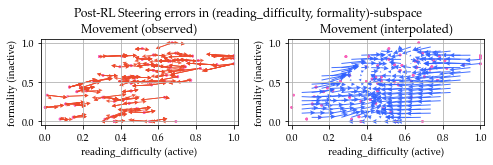

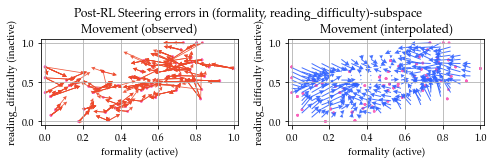

In [ ]:
get_pairwise_flows(staged[-1], "Post-RL", exp_name="llama_post_rl", steering_goals=["reading_difficulty", "formality"])

# Goal flow diagrams

In [ ]:
from scipy.interpolate import griddata

def grab_subspace(df, *args, unspecified=True, specified_first=False, steering_goals=STEERING_GOALS):
    xy = df[[f"source_{g}" for g in args]] # can also ask for deltas
    source_df = get_dist_from_source(df, by_goal=True, steering_goals=steering_goals)
    dxdy = source_df[list(args)] # output - source
    dxdy_ideal = get_dist_requested(df, by_goal=True, steering_goals=steering_goals)[list(args)].fillna(0.)
    
    dxdy.columns = [f"d_{g}" for g in args]
    dxdy_ideal.columns = [f"d*_{g}" for g in args]
    final = pd.concat([xy, dxdy, dxdy_ideal], axis=1)
    if unspecified:
        final = final.loc[dxdy_ideal.sum(axis=1) == 0]
    elif specified_first:
        final = final.loc[(dxdy_ideal[f"d*_{args[0]}"].abs() > 0) & (dxdy_ideal[f"d*_{args[1]}"] == 0)] # TODO: make this work for >1 goal
    final.columns = ["x1", "x2", "dx1", "dx2", "dx1_ideal", "dx2_ideal"]
    return final

def flow_diagram(df, xname, yname, model_name, unspecified=False, specified_first=True, model_display_name=None,
                 mode="movement", drop_close=None, save=False, exp_name=None, steering_goals=STEERING_GOALS, flow_only=False):
    if mode not in ["movement", "distance_to_goal"]:
        raise ValueError(f"Unuspported mode: {mode}")

    if mode == "movement":
        name = "Movement"
    else:
        name = "Distance to goal"
    
    subspace = grab_subspace(df, xname, yname, unspecified=unspecified, specified_first=specified_first, steering_goals=steering_goals)
    
    # Create a subplot with two plots: raw data and interpolated data
    if flow_only: 
        fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
        movement_ax, flow_ax = None, ax
    else:
        fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
        movement_ax, flow_ax = ax
    suptitle = f"({xname}, {yname})-flow\n{model_name}"
    if model_display_name is not None:
        suptitle += f"\nModel: {model_display_name}"
    fig.suptitle(suptitle, y=0.9)
    
    xlabel = f"{xname} (active)"
    ylabel = f"{yname} (inactive)"

    z0_size = 10
    z0_color = "#fa5fbb"
    movement_color = "#ed492b"
    rawwidth = 5
    headwidth = 5
    arrowwidth = 0.004
    flow_width = 0.005
    
    if movement_ax is not None:
        movement_ax.scatter(subspace["x1"], subspace["x2"], marker=".", alpha=0.5, edgecolors=z0_color, facecolors="none", s=z0_size)
        if mode == "movement":
            movement_ax.quiver(subspace["x1"], subspace["x2"], subspace["dx1"], subspace["dx2"], scale=5, 
                    color=movement_color, alpha=0.9, headwidth=rawwidth, width=arrowwidth)
        else:
            x1, x2 = subspace["x1"], subspace["x2"]
            dx1, dx2 = subspace["dx1_ideal"] - subspace["dx1"], subspace["dx2_ideal"] - subspace["dx2"]
            if drop_close is not None:
                err_norm = np.sqrt(dx1 ** 2 + dx2 ** 2)
                err_mask = err_norm > drop_close
                x1, x2, dx1, dx2 = x1[err_mask], x2[err_mask], dx1[err_mask], dx2[err_mask]
            
            movement_ax.quiver(x1, x2, dx1, dx2, scale=10, color=movement_color,
                        alpha=0.9, headwidth=rawwidth, width=arrowwidth)
        
        movement_ax.set_title(f"{name} (observed)")
        movement_ax.set_xlabel(xlabel)
        movement_ax.set_ylabel(ylabel)
        movement_ax.set_xlim((-0.02, 1.02))
        movement_ax.set_ylim((-0.05, 1.05))
        movement_ax.grid(True)


    grid_x, grid_y = np.meshgrid(np.linspace(min(subspace["x1"]), max(subspace["x1"]), 20),
                                 np.linspace(min(subspace["x2"]), max(subspace["x2"]), 20))

    if mode == "movement":
        grid_u = griddata((subspace["x1"], subspace["x2"]), subspace["dx1"], (grid_x, grid_y), method='linear')
        grid_v = griddata((subspace["x1"], subspace["x2"]), subspace["dx2"], (grid_x, grid_y), method='linear')
    else:
        grid_u = griddata((subspace["x1"], subspace["x2"]), subspace["dx1_ideal"] - subspace["dx1"], (grid_x, grid_y), method='linear')
        grid_v = griddata((subspace["x1"], subspace["x2"]), subspace["dx2_ideal"] - subspace["dx2"], (grid_x, grid_y), method='linear')

    
    # Plot the interpolated data
    flow_ax.scatter(subspace["x1"], subspace["x2"], marker=".", alpha=0.5,
                    edgecolors=z0_color, facecolors="none", s=z0_size)

    flow_ax.quiver(grid_x, grid_y, grid_u, grid_v, scale=5, color='#3061ff', headwidth=headwidth, width=flow_width, alpha=0.9)
    flow_ax.set_title(f"{name} (interpolated)")
    flow_ax.set_xlabel(xlabel)
    flow_ax.set_ylabel(ylabel)
    flow_ax.set_xlim((-0.02, 1.02))
    flow_ax.set_ylim((-0.05, 1.05))
    flow_ax.grid(True)

    plt.tight_layout()
    if save:
        plt.savefig(f"./figures/flows/{exp_name}_{mode}_flow_{xname}_{yname}_subspace.pdf")
    plt.show()
    return subspace


from itertools import product

def get_pairwise_flows(df, model_name, steering_goals=STEERING_GOALS, exp_name="", flow_only=False):
    for x, y in product(steering_goals, steering_goals):
        if x != y:
            flow_diagram(df, x, y, model_name, specified_first=True, unspecified=False,
                         mode="movement", save=True, exp_name=exp_name, steering_goals=steering_goals, flow_only=flow_only)

    

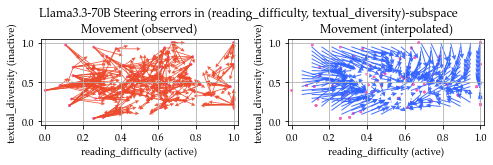

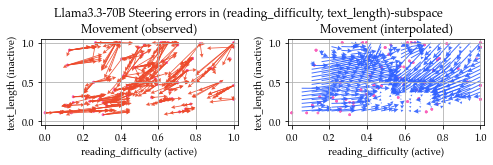

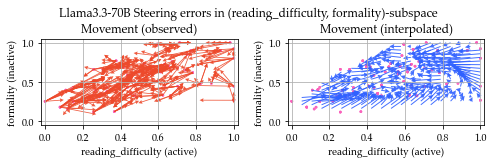

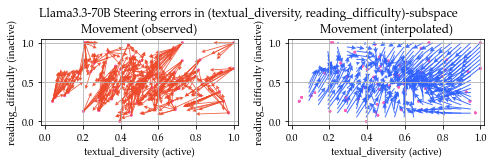

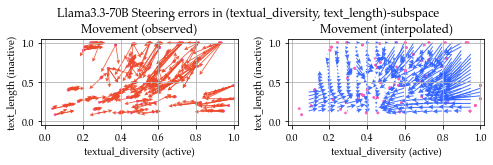

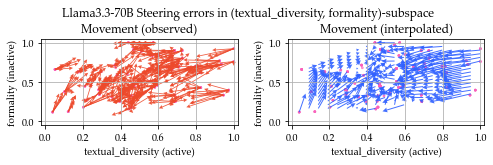

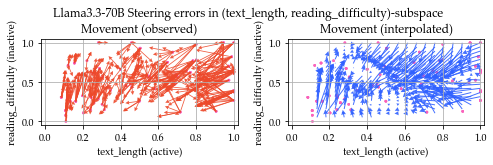

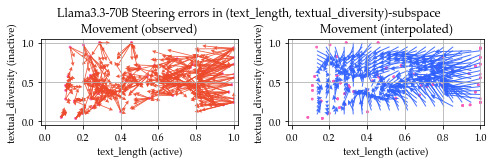

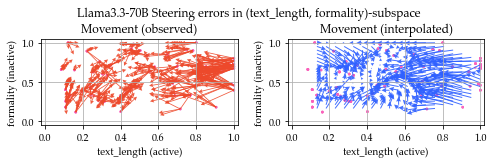

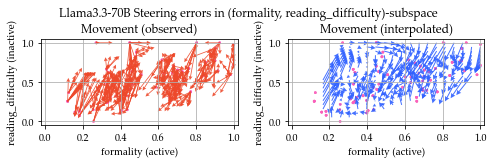

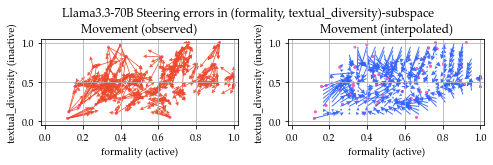

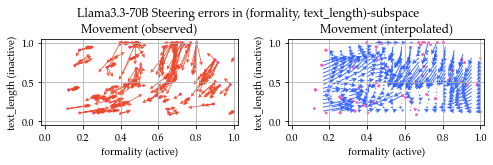

In [ ]:
get_pairwise_flows(models[4], "Llama3.3-70B", exp_name="llama3_70b_negprompt", flow_only=False)